In [1]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib
import datetime
import sklearn

In [2]:
matplotlib.style.use('seaborn')

In [3]:
beta = 2

### Data Preparation:

In [4]:
data = pd.read_csv("sap_stock.txt")

df = pd.DataFrame(data, columns=['Close'])
df = df.reset_index()

In [5]:
x = df["index"].to_numpy().reshape(-1)[0:100]
y = df["Close"].to_numpy().reshape(-1)[0:100]

In [6]:
x = x
y = y + np.random.normal(0.0, (1 / beta), size=100)

In [7]:
def kernelize(data, k=5):
    temp = np.zeros([data.shape[0], k])
    for i in range(k):
        temp[:, i] = data**i
    return temp

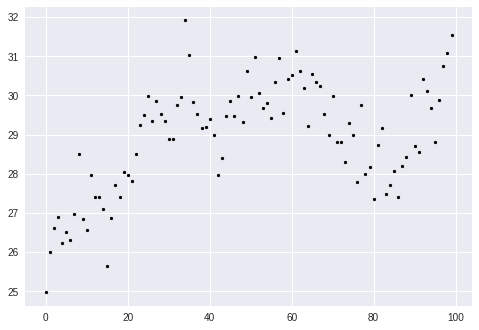

In [8]:
plt.scatter(x, y, marker='x', c='black', s=5);

# Maximum Likelihood Estimation:

In [9]:
def MLE(X, y):
    return (np.linalg.inv(X.T @ X) @ X.T @ y)

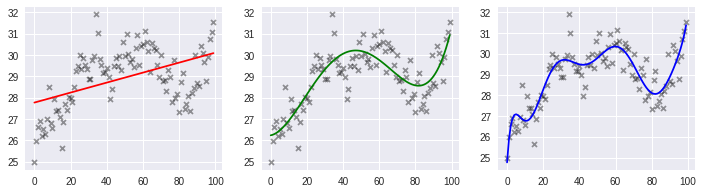

In [10]:
hparams = {2: 'red', 5: 'green', 10: 'blue'}

fig, ax = plt.subplots(1, 3, False, False, figsize=[12, 3])

ctr = 0
for k, color in hparams.items():
    
    train_x = kernelize(x, k)
    w_mle = MLE(train_x, y)
    
    # Plots:
    ax[ctr].scatter(x, y, marker='x', color='black', s=25, alpha=0.4)
    ax[ctr].plot(x, train_x @ w_mle, c=color)
    ctr += 1

plt.show()

# MAP Estimation:

In [11]:
def MAP(X, y, lambd, beta):
    return (np.linalg.inv((X.T @ X) + ((lambd / beta) * np.eye(X.shape[1]))) @ X.T @ y)

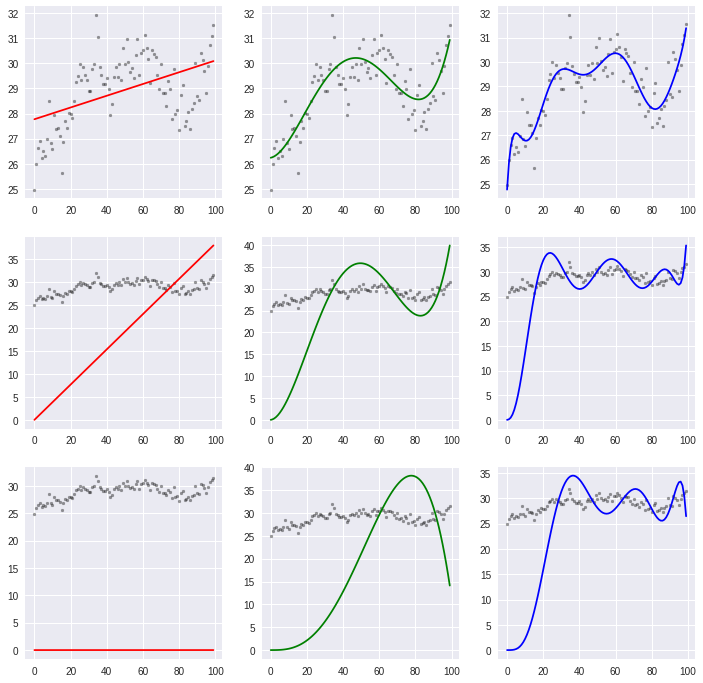

In [12]:
hparams = {2: 'r', 5: 'g', 10: 'b'}

fig, ax = plt.subplots(3, 3, False, False, figsize=[12, 12])

params_lambd = [0, 1e5, 1e10]
params_beta = [beta]*3

for t in range(3):
    ctr = 0
    for k, color in hparams.items():
        
        train_x = kernelize(x, k)
        w_map = MAP(train_x, y, params_lambd[t], params_beta[t])
        
        # Plots:
        ax[t, ctr].scatter(x, y, marker='x', color='black', s=5, alpha=0.4)
        ax[t, ctr].plot(x, train_x @ w_map, c=color)
        ctr += 1

plt.show()

In [13]:
def PosteriorEstimation(tx, y, lambd, beta):

    avg = np.linalg.inv((tx.T @ tx) + (lambd / beta) * np.eye(tx.shape[1])) @ tx.T @ y
    cov = np.linalg.inv(beta * (tx.T @ tx) + lambd * np.eye(tx.shape[1]))

    return avg, cov

In [14]:
def PPD(tx, y, avg, cov, beta):

    ppd_avg = (avg.reshape(1, tx.shape[1]) @ tx.T)
    ppd_var = (1 / beta) + (tx @ cov @ tx.T)

    return ppd_avg, ppd_var

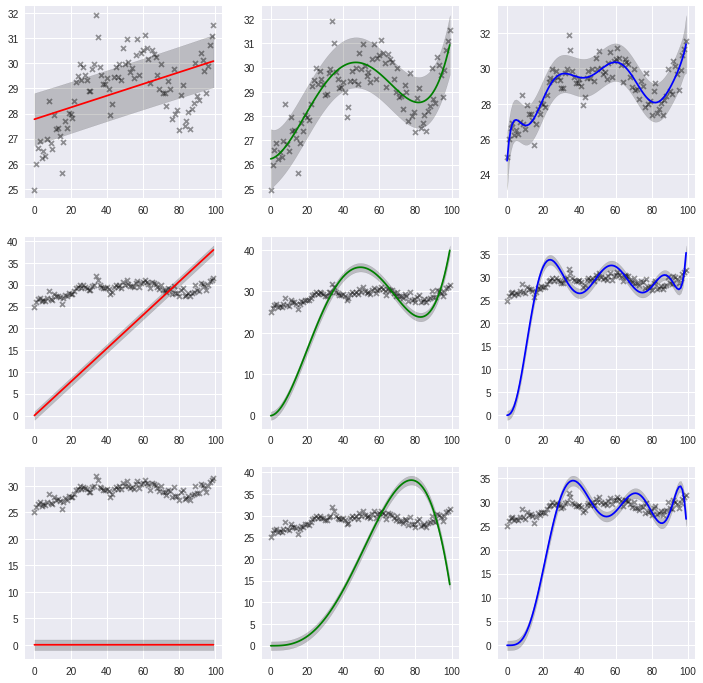

In [15]:
hparams = {2: 'r', 5: 'g', 10: 'b'}

fig, ax = plt.subplots(3, 3, False, False, figsize=[12, 12])

params_lambd = [0, 1e5, 1e10]
params_beta = [beta]*3

for t in range(3):
    ctr = 0
    for k, color in hparams.items():
        
        train_x = kernelize(x, k)
        avg, cov = PosteriorEstimation(train_x, y, params_lambd[t], params_beta[t])
        
        mean = []
        above = []
        below = []
        for s in range(len(train_x)):
            mu, var = PPD(train_x[s:s+1], y[s:s+1], avg, cov, params_beta[t])
            mean += [mu[0][0]]
            above += [mu[0][0] + (2 * var[0][0])]
            below += [mu[0][0] - (2 * var[0][0])]

        # Plots:
        ax[t, ctr].fill_between(x, above, below, alpha=0.2, color='black')
        ax[t, ctr].plot(x, mean, c=color)
        ax[t, ctr].scatter(x, y, marker='x', color='black', s=25, alpha=0.4)
        ctr += 1

plt.show()

### Using Sklearn Package:

In [16]:
from sklearn.linear_model import BayesianRidge

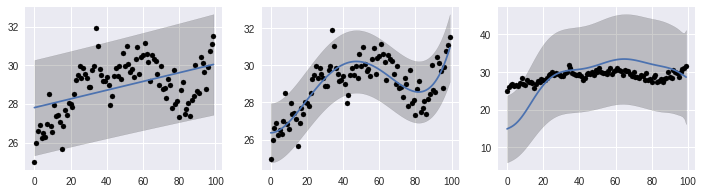

In [17]:
fig, ax = plt.subplots(1, 3, False, False, figsize=[12, 3])

order = [2, 5, 10]

for k in range(3):
    model = BayesianRidge()
    model.fit(kernelize(x, order[k]), y)
    mean, var = model.predict(kernelize(x, order[k]), return_std=True)

    upper = [(mean[i] - (2 * var[i])) for i in range(len(x))]
    average = [mean[i] for i in range(len(x))]
    lower = [(mean[i] + (2 * var[i])) for i in range(len(x))]

    ax[k].scatter(x, y, c='black', s=25)
    ax[k].plot(x, average)
    ax[k].fill_between(x, upper, lower, color='black', alpha=0.2)

plt.show()